## Stimulus-related behavior
Notebook created for detection of SRB frames.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate


%matplotlib inline
sns.set(color_codes=True)
pd.options.mode.chained_assignment = None 


# data loading
path = '../datasets/'
dfrat     = pd.read_hdf(path+'velocityDatabase.h5', 'Rat_Behavior').set_index('index')
dfevent   = pd.read_hdf(path+'velocityDatabase.h5', 'Events').set_index('index')
dfsession = pd.read_hdf(path+'velocityDatabase.h5', 'Sessions').set_index('index')


In [2]:
# remove unused columns
dfratdrop = dfrat.drop({'lx1', 'lz1', 'V1', 'lVo', 'theta'}, axis=1)
dfeventsClean = dfevent.drop({'MotiveExpTimeSecs'}, axis=1)

dfratmerge = pd.merge(dfratdrop, dfeventsClean, on=['Time', 'session_id','Frame'])

In [3]:
# smoothig velocity data
dfSRB = pd.DataFrame()
for name, dd in dfratmerge.groupby('session_id'):
    dd['UM'] = dd['U'].rolling(window=20).mean()   
    dfSRB = pd.concat([dfSRB, dd], axis=0, ignore_index=True)


In [4]:
dfSRB.head()

,Frame,Time,X_Pos,Y_Pos,Z_Pos,session_id,X_Ori,Y_Ori,Z_Ori,dT,V1_ori,lx1_ori,lz1_ori,U,visible,speed,UM
0,145,0.604167,-0.067320,0.096008,-0.051826,0,-0.885878,0.136246,-0.425116,0.004167,0.982600,-360.565381,-173.028531,5.216239,0,0.0,NaN
1,146,0.608333,-0.067240,0.096397,-0.051934,0,-0.885726,0.141832,-0.424598,0.004166,0.982239,-360.636049,-172.881191,5.619484,0,0.0,NaN
2,147,0.612500,-0.067161,0.096774,-0.052030,0,-0.885525,0.146949,-0.423919,0.004167,0.981764,-360.728479,-172.688248,7.355371,0,0.0,NaN
3,148,0.616667,-0.067087,0.097144,-0.052120,0,-0.885316,0.151729,-0.423101,0.004167,0.981223,-360.842412,-172.450051,9.077926,0,0.0,NaN
4,149,0.620833,-0.067017,0.097504,-0.052203,0,-0.885108,0.156241,-0.422182,0.004166,0.980639,-360.972307,-172.177990,10.367488,0,0.0,NaN


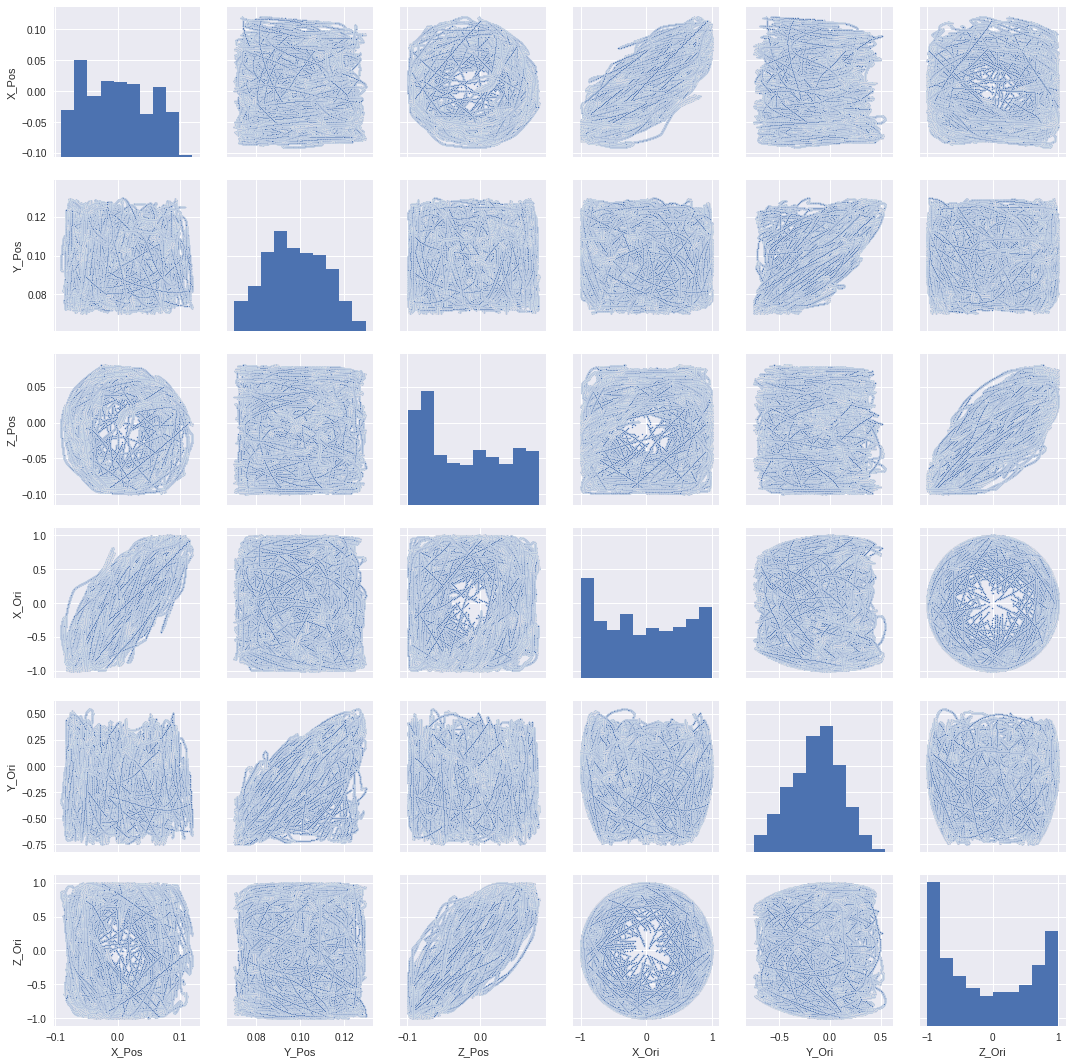

In [8]:
sns.pairplot(dfrat, vars=['X_Pos', 'Y_Pos', 'Z_Pos','X_Ori', 'Y_Ori', 'Z_Ori'], plot_kws={"s": 3});

In [ ]:
g = sns.FacetGrid(data=dfSRB, size=6, aspect=2, hue='session_id')
g.map(plt.scatter, 'Y_Pos', 'U', alpha=0.2, s=0.1);

g = sns.FacetGrid(data=dfSRB, size=6, aspect=2)
g.map(plt.scatter, 'Y_Ori', 'U', alpha=0.2, s=0.1);


## Basic threshold analysis

SRB = {f E FRAMES: ||Vhead - Vstim|| < Dmax}

to be extended

In [ ]:
# substracting the angular velocity of the rat and experiment 
dfSRB['subUM'] = dfSRB['speed'] - dfSRB['UM'] 
dfSRB['subU']  = dfSRB['speed'] - dfSRB['U'] 
dfSRB = dfSRB.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
## DISTRIBUTION OF ANGULAR VELOCITY IN Y AXIS
g = sns.FacetGrid(hue='session_id', data=dfSRB, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfSRB, size=4, aspect=2, hue_order=[1,2])
g.map(sns.distplot, 'subU');

g = sns.FacetGrid(hue='session_id', data=dfSRB, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "subUM", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfSRB, size=4, aspect=2, hue_order=[1,2])
g.map(sns.distplot, 'subUM');


In [ ]:
## ROUGH SRB CALCULATIONS TO BE CLEANED UP AND ANALYSED

# setting Dmax as 20% of velocity at given moment // what about 0
DmaxPerc = 0.2
dfSRB['Dmax'] = dfSRB.speed * DmaxPerc
# dfV['Dmax'] = lambda dfV: 0.1 if dfV.Dmax == 0 else dfV.Dmax

dfSRB['SRB_U']  = np.absolute(dfSRB['subU'].values)  < np.absolute(dfSRB['Dmax'].values)
dfSRB['SRB_UM'] = np.absolute(dfSRB['subUM'].values) < np.absolute(dfSRB['Dmax'].values)


In [ ]:
## SRB PER EXPERIMENT
sumFrameexp  = {}
sumSRBexp_UM = {}
sumSRBexp_U  = {}

for i, dd in dfSRB.groupby('session_id'):
    sumFrameexp[i] = len(dd.Frame)    
    sumSRBexp_U[i] = len(dd[dd['SRB_U']])
    print('stimulus-related behavior exp %d UM : %f%%'  % (i, sumSRBexp_U[i]  * 100 / sumFrameexp[i]))

print()
for i, dd in dfSRB.groupby('session_id'):
    sumSRBexp_UM[i] = len(dd[dd['SRB_UM']])    
    print('stimulus-related behavior exp %d UM : %f%%'  % (i, sumSRBexp_UM[i]  * 100 / sumFrameexp[i]))

In [ ]:
g = sns.FacetGrid( data=dfSRB[dfSRB['SRB_UM']], size=6, aspect=2, xlim=[-25,25], col='visible', hue='speed')
g.map(plt.scatter,'U', "Y_Pos", alpha=0.5, s=1);

g = sns.FacetGrid( data=dfSRB[(dfSRB['SRB_UM']) & (np.absolute(dfSRB['U'])<50)], col='visible', size=4, aspect=2, hue='speed')#, hue_order=[1,2])
g.map(sns.distplot, 'U');

In [ ]:
g = sns.FacetGrid( data=dfSRB[dfSRB['SRB_U']], size=6, aspect=2, xlim=[-25,25], col='visible', hue='speed')
g.map(plt.scatter,'U', "Y_Pos", alpha=0.5, s=1);

g = sns.FacetGrid( data=dfSRB[(dfSRB['SRB_U']) & (np.absolute(dfSRB['U'])<50)], col='visible', size=4, aspect=2, hue='speed')#, hue_order=[1,2])
g.map(sns.distplot, 'U');